## Arrythmia Detection using 1D-CNN

In [27]:
# importing important libraries for data mauplation
import numpy as np 
import pandas as pd 
import os

import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
# Libraries for implemntation of CNN
import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras.models import Sequential, Model

# Libraries for perfomance evaluation
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
# libraries for plots
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
#setting template for plots and figures
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [29]:
# Denoising function to perform DWT wavelet transfrom
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [30]:
# Setting required parameters for taking input
path = 'C:/Users/janya/Desktop/UNI MELB/SEM 2 2022/Project/Implementation/archive/mitbih_database/'
#window size to resample the signals
window_size = 180
maximum_counting = 10000
# hard coding the annotation clases
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [31]:
# Read files using the path variable
filenames = next(os.walk(path))[2]
# Split and save .csv , .txt 
# creating empty lists for records and annotations
records = list()
annotations = list()
filenames.sort()

In [32]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

## Pre_Processing and Visulaisation of ECG signals

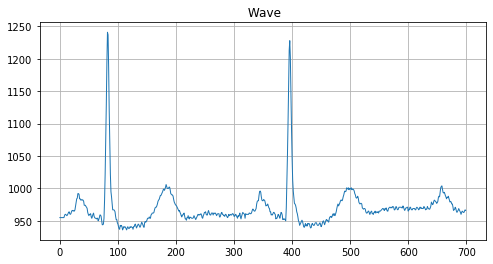

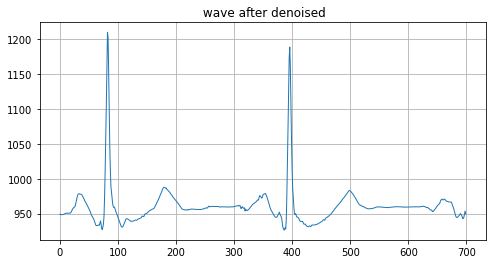

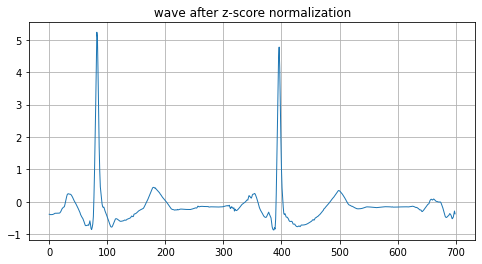

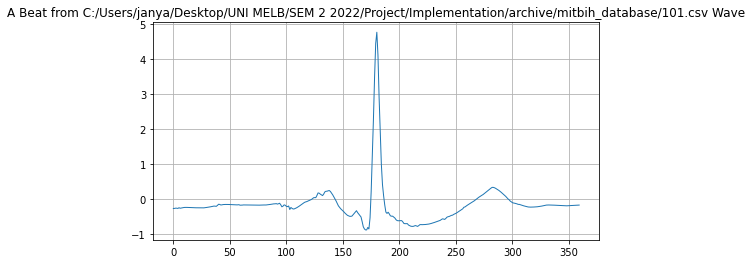

(100012, 360) (100012,)


In [33]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(" Wave")
        plt.plot(signals[0:700])
        plt.show()
    # Denoising of the signal using Denoise function
    signals = denoise(signals)
    if r is 1:
        # Plot each patient's signal
        plt.title(" wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
    # zscore normalisation of the signal
    signals = stats.zscore(signals)
    if r is 1:
        # Plot each patient's signal
        plt.title(" wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()
        # resampling and mapping annotations to records
        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]   
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    #appending the beat and corresponding annotation to X,y
                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [34]:
# Merging X and Y to make 1 single Nupmy array 
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


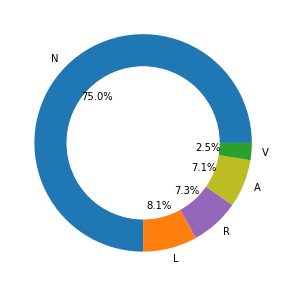

In [35]:
# Checking for distribution of classes in the dataset (we have a case of class imbalance here)
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [36]:
#dividing the dataset into 4 parts and downsampling/upsampling them to 5000 records so that all the outcomes have equal 
#number of observations (solving the class imbalance problem)
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

4.0    5000
3.0    5000
2.0    5000
1.0    5000
0.0    5000
Name: 360, dtype: int64


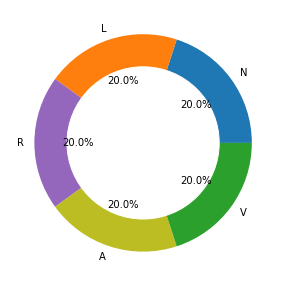

In [37]:
# Distribution of classes after resampling
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [38]:
# Using train test split to split the data into training and test data
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [39]:
# reshaping the dependent variable data (train_y,test_y)to fit into CNN Model
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [40]:
# reshaping the independent data (train_x,test_x) to fit into CNN Model
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x)) 

(20000, 360, 1) (5000, 360, 1)


In [41]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))

# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d_5 (Average (None, 179, 16)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_6 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_7 (Average (None, 44, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 44, 128)          

In [42]:
#compiling the model with loss function as categorical_crossentropy,optimiser as Adam and metric as Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [43]:
history = model.fit(train_x, train_y, batch_size=36, epochs=10, verbose=1, validation_data=(test_x, test_y))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 18s 876us/step - loss: 0.3336 - accuracy: 0.8887 - val_loss: 0.1299 - val_accuracy: 0.9600
Epoch 2/10
20000/20000 [==============================] - 17s 834us/step - loss: 0.1403 - accuracy: 0.9550 - val_loss: 0.0949 - val_accuracy: 0.9728
Epoch 3/10
20000/20000 [==============================] - 19s 938us/step - loss: 0.1104 - accuracy: 0.9674 - val_loss: 0.0852 - val_accuracy: 0.9768
Epoch 4/10
20000/20000 [==============================] - 17s 830us/step - loss: 0.0942 - accuracy: 0.9732 - val_loss: 0.0847 - val_accuracy: 0.9772
Epoch 5/10
20000/20000 [==============================] - 16s 819us/step - loss: 0.0859 - accuracy: 0.9752 - val_loss: 0.0634 - val_accuracy: 0.9840
Epoch 6/10
20000/20000 [==============================] - 16s 813us/step - loss: 0.0693 - accuracy: 0.9811 - val_loss: 0.0825 - val_accuracy: 0.9808
Epoch 7/10
20000/20000 [==============================] -

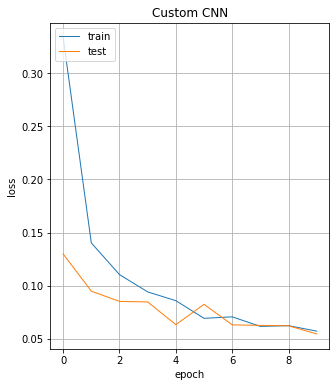

<Figure size 360x432 with 0 Axes>

In [44]:
# summarize history for loss

plt.rcParams["figure.figsize"] = (5,6)
plt.rcParams['axes.grid'] = True 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Custom CNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('cusCNNloss.png')

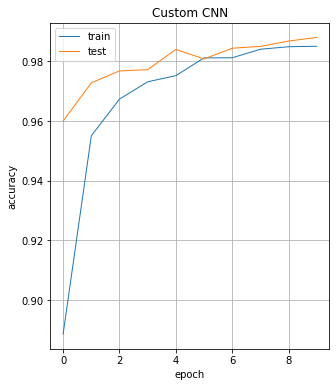

<Figure size 360x432 with 0 Axes>

In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Custom CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('CustCnnAcc.png')

In [46]:
#evaluating the model on test data
score = model.evaluate(test_x, test_y)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 1s 211us/step
Test Loss: 0.05459789873659611
Test accuracy: 0.9879999756813049


<AxesSubplot:>

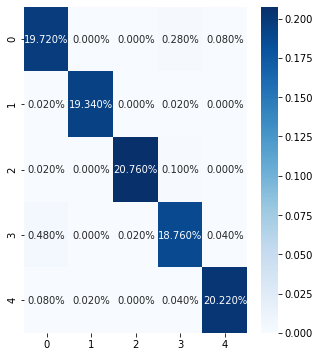

In [47]:
# confusion matrix for multiclass classifier
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat/np.sum(custCnnConfMat), annot=True,fmt='.3%', cmap='Blues')


In [48]:
# Overall Precision recall and accuracy for the test data
print('Precision: %.3f' % precision_score(y_true, prediction, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true, prediction, average='micro'))
print('Recall: %.3f' % recall_score(y_true, prediction, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true, prediction))

Precision: 0.988
F1 Score: 0.988
Recall: 0.988
Accuracy: 0.988


In [50]:
# classification report for precision, recall and accuracy of all the classes
from sklearn.metrics import classification_report

print(classification_report(y_true, prediction))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1004
           1       1.00      1.00      1.00       969
           2       1.00      0.99      1.00      1044
           3       0.98      0.97      0.97       965
           4       0.99      0.99      0.99      1018

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

